# Part 05: Tabulate statistics on the street disconntinuties
michael babb  
2024 11 24

In [1]:
# standard
import os

In [2]:
# external
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# custom
import run_constants as rc
from utils import *

# output excel file

In [4]:
ofpn = os.path.join(rc.ANALYSIS_OUTPUT_FILE_PATH, rc.S05_ANALYSIS_OUT_FILE_NAME)

In [5]:
e_writer = pd.ExcelWriter(path = ofpn)

# load the street network data

In [6]:
fpn = os.path.join(rc.OUTPUT_FILE_PATH, rc.S05_MISSING_IN_FILE_NAME)

In [7]:
gdf = gpd.read_file(filename = fpn)

In [8]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry'],
      dtype='object')

In [9]:
gdf['n_segments'] = int(1)

In [10]:
# add text descriptions for the street type categories
street_status_dict = {0:'continuous_street',
                1:'discontinuous_street',
                2:'added_street: within-sector',
                3:'added_street: cross-sector'}

In [11]:
gdf['street_status_desc'] = gdf['street_status'].map(street_status_dict)

In [12]:
# number of segments
gdf['street_status_desc'].value_counts()

street_status_desc
discontinuous_street           21940
continuous_street               3810
added_street: within-sector     3617
added_street: cross-sector       410
Name: count, dtype: int64

In [ ]:
# which street name columns feature ''?
gdf.columns

In [13]:
'' in gdf['ord_stname_concat'].unique().tolist()


False

In [14]:
'' in gdf['ord_stname_unique'].unique().tolist()

False

In [16]:
check_df = gdf.loc[(gdf['ord_stname_unique'] == '') &
                (gdf['street_status'] == 2), :]

In [17]:
check_df.head()

,snd_id,ord_street_name,ord_street_type,ord_stname_type,ord_stname_concat,ord_stname_unique,ord_stname_type_group,ord_street_type_rank,snd_group,group_id,city_sector,city_sector_group,street_status,sn_id,en_id,dist,dist_miles,geometry,n_segments,street_status_desc


In [18]:
# simple count of road miles
col_names = ['street_status_desc', 'dist_miles']
gdf_agg = gdf[col_names].groupby(col_names[:-1]).agg(n_miles = ('dist_miles', 'sum')).reset_index()

In [19]:
# total road miles
gdf_agg.head()

,street_status_desc,n_miles
0,added_street: cross-sector,823.728529
1,added_street: within-sector,833.487569
2,continuous_street,311.804778
3,discontinuous_street,1578.369226


In [20]:
col_names = ['ord_stname_type_group', 'ord_stname_concat', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names].drop_duplicates().groupby(col_names[2:-1]).agg(n_roads = ('n_segments', 'sum')).reset_index()

In [21]:
gdf_agg.head()

,street_status_desc,n_roads
0,added_street: cross-sector,313
1,added_street: within-sector,1103
2,continuous_street,1145
3,discontinuous_street,1308


In [23]:
# number of added segments
gdf['street_status_desc'].value_counts()

street_status_desc
discontinuous_street           21940
continuous_street               3810
added_street: within-sector     3617
added_street: cross-sector       410
Name: count, dtype: int64

In [24]:
# within-sector: average number of segments added per uniquely named road
3617 / 1103

3.2792384406165005

# q1: are cross-sector added streets correct?

In [25]:
gdf.columns

Index(['snd_id', 'ord_street_name', 'ord_street_type', 'ord_stname_type',
       'ord_stname_concat', 'ord_stname_unique', 'ord_stname_type_group',
       'ord_street_type_rank', 'snd_group', 'group_id', 'city_sector',
       'city_sector_group', 'street_status', 'sn_id', 'en_id', 'dist',
       'dist_miles', 'geometry', 'n_segments', 'street_status_desc'],
      dtype='object')

In [26]:
col_names = ['ord_stname_type_group', 'street_status', 'n_segments']

In [27]:
# pivot
gdf_agg = pd.pivot_table(data = gdf, values = 'n_segments', index = ['ord_stname_type_group'],
                         columns = ['street_status'], aggfunc='sum', fill_value=0)

In [28]:
# rename columns
gdf_agg.columns = ['ss_' + str(x) for x in range(0, 4)]

In [29]:
gdf_agg = gdf_agg.reset_index()

In [30]:
# perform a series of tests to identify the multi_sector street
gdf_agg['is_multi_sector'] = int(0)

In [31]:
gdf_agg.loc[gdf_agg['ord_stname_type_group'].str.find('_') > 0, 'is_multi_sector'] = int(1)

In [32]:
# false negatives: an added segment is not marked cross-sector when it should be
gdf_agg['check_street_fn'] = int(0)

In [33]:
gdf_agg.loc[(gdf_agg['is_multi_sector'] == 1) &
            (gdf_agg['ss_3'] == 0), 'check_street_fn'] = int(1)

In [34]:
gdf_agg['check_street_fn'].sum()

76

In [35]:
# false positives: an added segment is marked cross-sector when it should not be
gdf_agg['check_street_fp'] = int(0)
gdf_agg.loc[(gdf_agg['is_multi_sector'] == 0) &
            (gdf_agg['ss_3'] != 0), 'check_street_fp'] = int(1)

In [36]:
gdf_agg['check_street_fp'].sum()

0

In [37]:
# we only have false negatives. Let's highlight those

In [38]:
check_gdf_agg = gdf_agg.loc[(gdf_agg['check_street_fn'] == 1) |
                      (gdf_agg['check_street_fp'] == 1), :]

In [39]:
# export these streets
check_gdf = gdf.loc[gdf['ord_stname_type_group'].isin(check_gdf_agg['ord_stname_type_group']), :]

In [40]:
check_gdf['ord_stname_type_group'].unique().shape

(76,)

In [41]:
# visualize
write_gdf(gdf = check_gdf, output_file_path=rc.OUTPUT_FILE_PATH, output_file_name=rc.S05_STREET_CONNECTION_CHECK_FILE_NAME)

In [42]:
# okay, after looking at these segments in qGIS - they appear to be correct. 
# this is because the existing street crosses from one sector of the city to 
# another, but the added segments are all within-sector. So in a way, by a
# strict definition, these are false negatives, but these streets are correct. 

# q2: what street name - excluding direction - has the most street types?

In [51]:
col_names = ['ord_street_name', 'ord_street_type', 'n_segments']

In [53]:
gdf_agg = gdf.loc[gdf['street_status'].isin((0,1)), col_names].drop_duplicates()

In [54]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['ord_street_type'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [55]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [56]:
gdf_pv.head()

,ord_street_name,AVE,BLVD,BR,CIR,CT,DR,LN,LOOP,PKWY,PL,PZ,RD,ST,TER,VIEW,WAY,All
0,100TH,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
1,101ST,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
2,102ND,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2
3,103RD,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2
4,104TH,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,4


In [57]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 's_type_count', index = False)

# q3: what street name - excluding type - has the most street connections?

In [61]:
col_names = ['ord_street_name', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names].drop_duplicates()

In [62]:
gdf_pv = pd.pivot_table(data = gdf_agg, values = ['n_segments'], index = 'ord_street_name', columns = ['street_status_desc'],
                        aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [63]:
gdf_pv.head()

ord_street_name                 n_segments  \
street_status_desc                 added_street: cross-sector   
0                            100TH                          1   
1                            101ST                          1   
2                            102ND                          1   
3                            103RD                          1   
4                            104TH                          1   

                                                                  \
street_status_desc added_street: within-sector continuous_street   
0                                            1                 1   
1                                            1                 1   
2                                            1                 1   
3                                            1                 1   
4                                            1                 1   

                                             
street_status_desc discontinuous_street All  
0                                     1   4  
1                                     1   4  
2                                     1   4  
3                                     1   4  
4                                     1   4

In [64]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [65]:
gdf_pv.columns

Index(['ord_street_name', 'added_street: cross-sector',
       'added_street: within-sector', 'continuous_street',
       'discontinuous_street', 'All'],
      dtype='object')

In [66]:
gdf_pv.head()

,ord_street_name,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street,All
0,100TH,1,1,1,1,4
1,101ST,1,1,1,1,4
2,102ND,1,1,1,1,4
3,103RD,1,1,1,1,4
4,104TH,1,1,1,1,4


In [67]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_by_name', index = False)

# q4: what street name - including direction and type - has the most street connections?

In [ ]:
col_names = ['ord_stname_type_group', 'ord_stname_unique', 'ord_stname_concat', 'ord_street_type', 'street_status', 'street_status_desc', 'n_segments']
gdf_agg = gdf[col_names]

In [68]:
gdf_pv = pd.pivot_table(data = gdf, values = ['n_segments'], index = ['ord_stname_unique', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [69]:
gdf_pv.columns = [''.join(cn).replace('n_segments', '') for cn in gdf_pv.columns]

In [70]:
gdf_pv.head()

,ord_stname_unique,ord_street_type,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street,All
0,100TH ST NW_N_NE,ST,1,0,0,0,1
1,101ST ST SW_S,ST,1,0,0,0,1
2,102ND ST N_NE,ST,1,0,0,0,1
3,103RD ST NW_N_NE,ST,2,0,0,0,2
4,103RD ST SW_S,ST,1,0,0,0,1


In [71]:
# remove the all row
gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_unique'] != 'All', :]

In [72]:
gdf_pv.shape

(2768, 7)

# q5: what are the streets with at least 10 discontinuities?

In [73]:
gdf_pv.loc[gdf_pv['added_street: within-sector'] >= 10, 'ord_stname_unique'].tolist()

['12TH AVE S',
 '16TH AVE S',
 '1ST AVE NW',
 '22ND AVE NE',
 '24TH AVE NE',
 '24TH AVE S',
 '26TH AVE NE',
 '29TH AVE S',
 '2ND AVE NE',
 '2ND AVE NW',
 '2ND AVE S',
 '30TH AVE S',
 '31ST AVE S',
 '35TH AVE S',
 '36TH AVE S',
 '36TH AVE SW',
 '38TH AVE NE',
 '3RD AVE S',
 '45TH AVE S',
 '46TH AVE S',
 '46TH AVE SW',
 '4TH AVE NE',
 'DENSMORE AVE N',
 'OCCIDENTAL AVE S',
 'PALATINE AVE N',
 'S CHARLES ST',
 'S FERDINAND ST',
 'S HINDS ST',
 'S HORTON ST',
 'S RAYMOND ST',
 'S ROSE ST',
 'SW SPOKANE ST',
 'W ARMOUR ST',
 'W BARRETT ST',
 'W RAYE ST']

In [74]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'connection_count_full_name', index = False)

# q6: what is the ratio of discontinuous to continuous streets?
looking at uniquely named streets

In [75]:
continuous_streets = gdf.loc[gdf['street_status'] == 0, 'ord_stname_unique'].unique().shape[0]
discontinuous_streets = gdf.loc[gdf['street_status'] == 1, 'ord_stname_unique'].unique().shape[0]
total_streets = continuous_streets + discontinuous_streets

In [76]:
continuous_streets / total_streets

0.4672097759674134

In [77]:
discontinuous_streets / total_streets

0.5327902240325866

In [78]:
# 47 percent of named streets are continuous.
# 53 percent of named streets are discontinous.
# this tracks

# q7: which streets feature longer discontinuous portions?

In [79]:
gdf_pv = pd.pivot_table(data = gdf, values = ['dist_miles'], index = ['ord_stname_type_group', 'ord_street_type'],
                        columns = ['street_status_desc'], aggfunc = 'sum', fill_value = 0, margins = True).reset_index()

In [80]:
gdf_pv.columns = [''.join(cn).replace('dist_miles', '') for cn in gdf_pv.columns]

In [81]:
gdf_pv.shape

(1815, 7)

In [82]:
gdf_pv = gdf_pv.loc[gdf_pv['ord_stname_type_group']!= 'All', :].copy()

In [83]:
gdf_pv.shape

(1814, 7)

In [84]:
gdf_pv.head()

,ord_stname_type_group,ord_street_type,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street,All
0,100TH PL NW,PL,0.000000,0.000000,0.201049,0.000000,0.201049
1,100TH PL SW,PL,0.000000,0.000000,0.035254,0.000000,0.035254
2,100TH ST NW_N_NE,ST,0.307315,0.653439,0.000000,4.535595,5.496349
3,100TH ST SW_S,ST,0.000000,0.761244,0.000000,2.970913,3.732157
4,101ST PL SW,PL,0.000000,0.000000,0.034279,0.000000,0.034279


In [86]:
gdf_pv['longer_added'] = int(0) # street is complete
gdf_pv.loc[(gdf_pv['continuous_street'] == 0) & (gdf_pv['added_street: within-sector'] <= gdf_pv['discontinuous_street']), 'longer_added'] = int(1)
gdf_pv.loc[(gdf_pv['continuous_street'] == 0) & (gdf_pv['added_street: within-sector'] > gdf_pv['discontinuous_street']), 'longer_added'] = int(2)

In [87]:
gdf_pv['longer_added'].value_counts()

longer_added
0    1113
1     543
2     158
Name: count, dtype: int64

In [88]:
gdf_pv.to_excel(excel_writer=e_writer, sheet_name = 'distance_full_name', index = False)

In [89]:
# road miles on streets with at least one added segment
split_streets = gdf_pv['discontinuous_street'].sum()
split_streets

1578.3692260090909

In [90]:
# road miles on streets with no added segments
continuous_streets = gdf_pv['continuous_street'].sum()
continuous_streets

311.80477796761363

In [91]:
split_streets / (split_streets + continuous_streets)

0.8350391142235514

In [92]:
continuous_streets / (split_streets + continuous_streets)

0.16496088577644857

In [93]:
# 84 percent of road miles are multi-segments streets
# 16 percent of road miles are single segment streets

# tabulate distances and distributions by street type

In [94]:
st_type_df = pd.pivot_table(data = gdf, index = ['ord_street_type'],
                         columns = ['street_status_desc'], values = ['dist_miles'],
                        aggfunc='sum', fill_value = 0).reset_index()



In [95]:
st_type_df.columns = [''.join(cn).replace('dist_miles', '') for cn in st_type_df.columns]

In [96]:
st_type_df.shape

(16, 5)

In [97]:
st_type_df.head()

,ord_street_type,added_street: cross-sector,added_street: within-sector,continuous_street,discontinuous_street
0,AVE,560.253713,431.877647,72.647575,857.534570
1,BLVD,0.046053,0.467329,16.408015,8.648006
2,BR,0.000000,0.000000,4.212091,0.000000
3,CIR,0.000000,0.000000,0.698582,0.000000
4,CT,3.848201,0.022490,4.254737,0.218229


In [98]:
# now, melt
st_type_df_melt = pd.melt(frame = st_type_df, id_vars = ['ord_street_type'],
                          var_name = 'street_status_desc',
                          value_name = 'total_miles')

In [99]:
st_type_df_melt.head()

,ord_street_type,street_status_desc,total_miles
0,AVE,added_street: cross-sector,560.253713
1,BLVD,added_street: cross-sector,0.046053
2,BR,added_street: cross-sector,0.000000
3,CIR,added_street: cross-sector,0.000000
4,CT,added_street: cross-sector,3.848201


In [100]:
col_names = ['ord_street_type', 'street_status_desc', 'dist_miles']

In [101]:
ds_st_df = gdf[col_names].groupby(col_names[:-1]).describe().reset_index()

In [102]:
ds_st_df.head()

ord_street_type           street_status_desc dist_miles                      \
                                                    count      mean       std   
0             AVE   added_street: cross-sector      193.0  2.902869  2.786502   
1             AVE  added_street: within-sector     1728.0  0.249929  0.402936   
2             AVE            continuous_street      906.0  0.080185  0.058779   
3             AVE         discontinuous_street    10531.0  0.081430  0.046233   
4            BLVD   added_street: cross-sector        1.0  0.046053       NaN   

                                                      
        min       25%       50%       75%        max  
0  0.007820  0.520193  1.504484  4.799009  11.127778  
1  0.002857  0.030614  0.095037  0.269936   3.739595  
2  0.003313  0.045066  0.067970  0.099905   0.639583  
3  0.001535  0.050360  0.069714  0.122449   0.633067  
4  0.046053  0.046053  0.046053  0.046053   0.046053

In [103]:
ds_st_df.columns =  [''.join(cn).replace('dist_miles', '') for cn in ds_st_df.columns]

In [104]:
ds_st_df.head()

,ord_street_type,street_status_desc,count,mean,std,min,25%,50%,75%,max
0,AVE,added_street: cross-sector,193.0,2.902869,2.786502,0.007820,0.520193,1.504484,4.799009,11.127778
1,AVE,added_street: within-sector,1728.0,0.249929,0.402936,0.002857,0.030614,0.095037,0.269936,3.739595
2,AVE,continuous_street,906.0,0.080185,0.058779,0.003313,0.045066,0.067970,0.099905,0.639583
3,AVE,discontinuous_street,10531.0,0.081430,0.046233,0.001535,0.050360,0.069714,0.122449,0.633067
4,BLVD,added_street: cross-sector,1.0,0.046053,NaN,0.046053,0.046053,0.046053,0.046053,0.046053


In [105]:
temp_ds_st_df = ds_st_df.loc[ds_st_df['street_status_desc'] == 'added_street', :].copy()

In [106]:
temp_ds_st_df = temp_ds_st_df.drop(labels = 'std', axis = 1)

In [107]:
temp_ds_st_df = temp_ds_st_df.sort_values(by = ['count'], ascending = False)

In [108]:
temp_ds_st_df.to_excel(excel_writer=e_writer, sheet_name = 'added_street_count', index = False)

In [109]:
st_type_df_melt.head()

,ord_street_type,street_status_desc,total_miles
0,AVE,added_street: cross-sector,560.253713
1,BLVD,added_street: cross-sector,0.046053
2,BR,added_street: cross-sector,0.000000
3,CIR,added_street: cross-sector,0.000000
4,CT,added_street: cross-sector,3.848201


In [110]:
ds_st_df.head()

,ord_street_type,street_status_desc,count,mean,std,min,25%,50%,75%,max
0,AVE,added_street: cross-sector,193.0,2.902869,2.786502,0.007820,0.520193,1.504484,4.799009,11.127778
1,AVE,added_street: within-sector,1728.0,0.249929,0.402936,0.002857,0.030614,0.095037,0.269936,3.739595
2,AVE,continuous_street,906.0,0.080185,0.058779,0.003313,0.045066,0.067970,0.099905,0.639583
3,AVE,discontinuous_street,10531.0,0.081430,0.046233,0.001535,0.050360,0.069714,0.122449,0.633067
4,BLVD,added_street: cross-sector,1.0,0.046053,NaN,0.046053,0.046053,0.046053,0.046053,0.046053


In [111]:
# join to get total miles and summary statistics
ds_st_df = pd.merge(left = st_type_df_melt, right = ds_st_df, how = 'left')

In [112]:
ds_st_df.head()

,ord_street_type,street_status_desc,total_miles,count,mean,std,min,25%,50%,75%,max
0,AVE,added_street: cross-sector,560.253713,193.0,2.902869,2.786502,0.007820,0.520193,1.504484,4.799009,11.127778
1,BLVD,added_street: cross-sector,0.046053,1.0,0.046053,NaN,0.046053,0.046053,0.046053,0.046053,0.046053
2,BR,added_street: cross-sector,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CIR,added_street: cross-sector,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CT,added_street: cross-sector,3.848201,1.0,3.848201,NaN,3.848201,3.848201,3.848201,3.848201,3.848201


In [113]:
ds_st_df.columns

Index(['ord_street_type', 'street_status_desc', 'total_miles', 'count', 'mean',
       'std', 'min', '25%', '50%', '75%', 'max'],
      dtype='object')

In [114]:
for cn in ds_st_df.columns:
    if ds_st_df[cn].dtype == 'float64':
        ds_st_df[cn] = ds_st_df[cn].fillna(0)

In [115]:
ds_st_df = ds_st_df.sort_values(by = ['ord_street_type', 'street_status_desc'])

In [116]:
ds_st_df['street_status_desc'] = ds_st_df['street_status_desc'].str.replace('_street', '')

In [117]:
# set index

In [118]:
ds_st_df = ds_st_df.set_index(keys = ['ord_street_type', 'street_status_desc'])

In [119]:
# reorder columns
col_names = ['count', 'min', '25%', '50%', 'mean', '75%', 'max', 'total_miles']
ds_st_df = ds_st_df[col_names]

In [120]:
ds_st_df.to_excel(excel_writer=e_writer, sheet_name = 'sum_stats', index = True)
                  

In [121]:
e_writer.close()

In [122]:
ds_st_df.head()

count       min       25%       50%  \
ord_street_type street_status_desc                                            
AVE             added: cross-sector     193.0  0.007820  0.520193  1.504484   
                added: within-sector   1728.0  0.002857  0.030614  0.095037   
                continuous              906.0  0.003313  0.045066  0.067970   
                discontinuous         10531.0  0.001535  0.050360  0.069714   
BLVD            added: cross-sector       1.0  0.046053  0.046053  0.046053   

                                          mean       75%        max  \
ord_street_type street_status_desc                                    
AVE             added: cross-sector   2.902869  4.799009  11.127778   
                added: within-sector  0.249929  0.269936   3.739595   
                continuous            0.080185  0.099905   0.639583   
                discontinuous         0.081430  0.122449   0.633067   
BLVD            added: cross-sector   0.046053  0.046053   0.046053   

                                      total_miles  
ord_street_type street_status_desc                 
AVE             added: cross-sector    560.253713  
                added: within-sector   431.877647  
                continuous              72.647575  
                discontinuous          857.534570  
BLVD            added: cross-sector      0.046053

# 10 longest added streets by cross-sector and within-sector

In [124]:
wms_gdf = gdf.loc[gdf['street_status'].isin([2,3]), :].copy()

In [125]:
wms_gdf['dist_rank'] = wms_gdf.groupby('street_status')['dist'].rank(method = 'dense', ascending = False)

In [127]:
wms_gdf.loc[wms_gdf['dist_rank'] <= 10, 'ord_stname_unique'].tolist()

['S 105TH ST',
 'S 106TH ST',
 'S 112TH ST',
 'S 116TH ST',
 '11TH AVE S',
 '12TH AVE SW',
 '33RD AVE SW',
 '51ST AVE SW',
 '58TH AVE NE_S',
 '59TH AVE NE_S',
 '60TH AVE NE_S',
 '61ST AVE NE_S',
 '62ND AVE NE_S',
 '63RD AVE NE_S',
 '64TH AVE NE_S',
 '65TH AVE NE_S',
 '7TH PL S',
 '9TH AVE S',
 'LAKE SHORE DR NE_S',
 'NEBRASKA ST W_S']

# histogram of all added streets

In [128]:
# log transform the distance in miles to prep for plotting
wms_gdf['dist_miles_log'] = np.log10(wms_gdf['dist_miles'])

In [129]:
wms_gdf['dist_miles_log'].describe()

count    4027.000000
mean       -0.925085
std         0.661113
min        -3.128428
25%        -1.451861
50%        -0.984131
75%        -0.462482
max         1.046408
Name: dist_miles_log, dtype: float64

In [133]:
# compute summary stats and create a dataframe
# the ds_df will hold values of interest to plot and plotting keywords for 
# those values
ds_df_list = []
for ss in [2,3]:
    ds_df = wms_gdf.loc[wms_gdf['street_status'] == ss, 'dist_miles'].describe().to_frame().reset_index(names = ['stat'])
    ds_df['street_status'] = ss
    ds_df_list.append(ds_df)
ds_df = pd.concat(ds_df_list)

In [135]:
ds_df.tail()

,stat,dist_miles,street_status
3,min,0.007820,3
4,25%,0.465272,3
5,50%,1.086217,3
6,75%,2.666548,3
7,max,11.127778,3


In [136]:
# remove the count and the standard deviation - not useful for plotting
ds_df = ds_df.loc[-ds_df['stat'].isin(['count', 'std']), :]

In [137]:
# add the 10th, 95th, and 99th precentiles
temp_stat_df_list = []
for ss in [2,3]:
    temp_values = wms_gdf.loc[wms_gdf['street_status'] == ss, 'dist_miles'].to_numpy()
    temp_stat_records = [
        ['10%', np.quantile(a = temp_values, q = 0.10), ss],
        ['95%', np.quantile(a = temp_values, q = 0.95), ss],
        ['99%', np.quantile(a = temp_values, q = 0.99), ss]
    ]
    temp_stat_df = pd.DataFrame(data = temp_stat_records, columns = ds_df.columns)
    temp_stat_df_list.append(temp_stat_df)

temp_stat_df = pd.concat(temp_stat_df_list)



In [138]:
# combine
ds_df = pd.concat(objs = [ds_df, temp_stat_df], axis = 0)

In [140]:
ds_df = ds_df.sort_values(by = ['street_status', 'dist_miles'])

In [141]:
ds_df['dist_miles_log'] = ds_df['dist_miles'].map(lambda x: np.log10(x))

In [142]:
# the color of the lines to add
ds_df['color_list'] = 'black'

In [143]:
# convert to feet to help with labeling
ds_df['dist_feet'] = ds_df['dist_miles'] * 5280

In [145]:
display(ds_df)

,stat,dist_miles,street_status,dist_miles_log,color_list,dist_feet
3,min,0.000744,2,-3.128428,black,3.928314
0,10%,0.018320,2,-1.737063,black,96.732168
4,25%,0.031744,2,-1.498338,black,167.608566
5,50%,0.084890,2,-1.071145,black,448.217700
1,mean,0.230436,2,-0.637449,black,1216.702893
6,75%,0.251245,2,-0.599902,black,1326.574912
1,95%,0.964556,2,-0.015673,black,5092.854199
2,99%,1.934898,2,0.286658,black,10216.259556
7,max,4.973674,2,0.696677,black,26261.000182
3,min,0.007820,3,-2.106767,black,41.292065


In [165]:
# this is the horizontal alignment of each piece of added text
ss_2_text_ha = ['left', 'center',  'center', 'right', 'right', 'left', 'center', 'center', 'right'] 
ss_3_text_ha = ['left', 'right',  'center', 'right', 'right', 'left', 'center', 'center', 'right'] 

text_ha = ss_2_text_ha[:]
text_ha.extend(ss_3_text_ha)
ds_df['text_ha'] = text_ha

In [166]:
# the text labels to add
ss_2_text = ['4ft (min.)', '97 ft (10%)', '167 ft (25%)', '448 ft (med.)', '0.23 mi (avg.)', '0.25 mi (75%)', '0.96 mi (95%)', '1.9 mi (99%)', '5 mi (max.)']
ss_3_text = ['42ft (min.)', '557 ft (10%)', '0.47 mi (25%)', '1.1 mi (med.)', '2.0 mi (avg.)', '2.7 mi (75%)', '6.7 mi (95%)', '10.7 mi (99%)', '11 mi (max.)']

text_labels = ss_2_text[:]
text_labels.extend(ss_3_text)
ds_df['text'] = text_labels

In [187]:
# jitter each piece of text by a small amount left or right
ss_2_text_jitter = [0, -.01, 0, .09, 0, 0, -.05, 0, 0]
ss_3_text_jitter = [0, .001, 0, .09, 0, 0, -.05, 0, 0]
text_jitter = ss_2_text_jitter[:]
text_jitter.extend(ss_3_text_jitter)

ds_df['text_jitter'] = text_jitter

In [188]:
# the horizontal position is created from the distance in miles and the text jitter
ds_df['text_x_pos'] = ds_df['dist_miles_log'] + ds_df['text_jitter']

In [189]:
ds_df.head(n=10)

,stat,dist_miles,street_status,dist_miles_log,color_list,dist_feet,text_ha,text,text_jitter,text_x_pos
3,min,0.000744,2,-3.128428,black,3.928314,left,4ft (min.),0.00,-3.128428
0,10%,0.018320,2,-1.737063,black,96.732168,center,97 ft (10%),-0.01,-1.747063
4,25%,0.031744,2,-1.498338,black,167.608566,center,167 ft (25%),0.00,-1.498338
5,50%,0.084890,2,-1.071145,black,448.217700,right,448 ft (med.),0.09,-0.981145
1,mean,0.230436,2,-0.637449,black,1216.702893,right,0.23 mi (avg.),0.00,-0.637449
6,75%,0.251245,2,-0.599902,black,1326.574912,left,0.25 mi (75%),0.00,-0.599902
1,95%,0.964556,2,-0.015673,black,5092.854199,center,0.96 mi (95%),-0.05,-0.065673
2,99%,1.934898,2,0.286658,black,10216.259556,center,1.9 mi (99%),0.00,0.286658
7,max,4.973674,2,0.696677,black,26261.000182,right,5 mi (max.),0.00,0.696677
3,min,0.007820,3,-2.106767,black,41.292065,left,42ft (min.),0.00,-2.106767


..\graphics\histogram_ws_ALL_streets.png


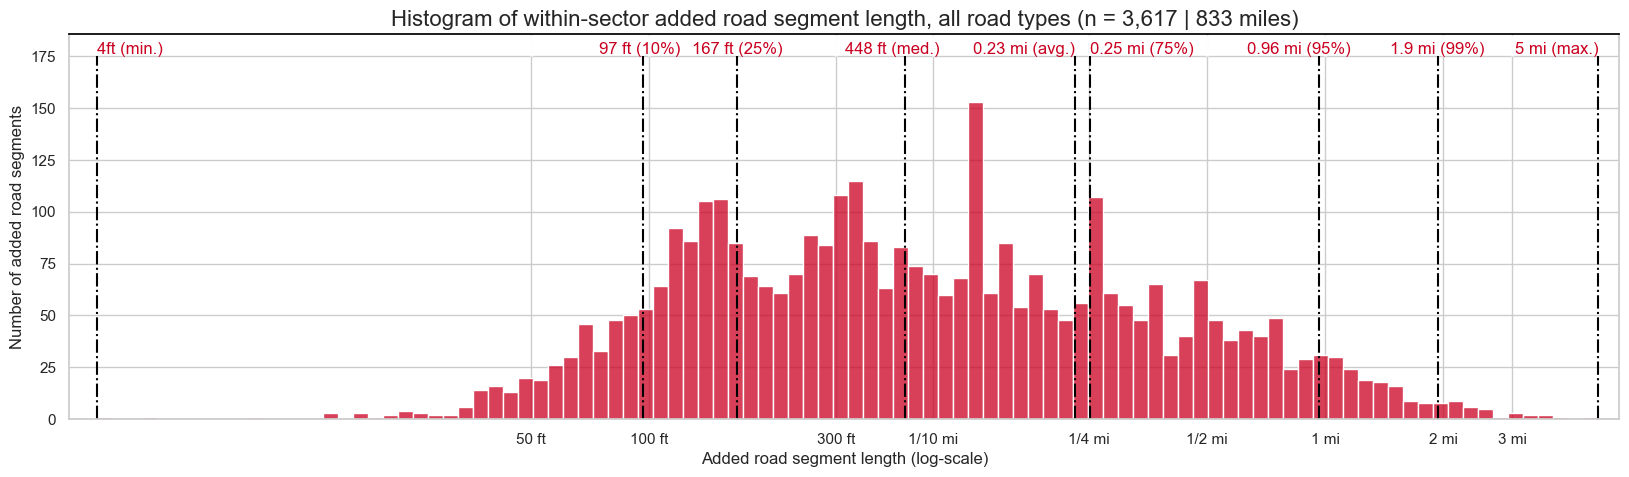

In [195]:
# compute the histogram of the added distribution - for within-sector added streets
working_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == 2, :]
w_ds_df = ds_df.loc[ds_df['street_status'] == 2, :]
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 185.6)
ax.set_xlim(-3.2, .75)

my_plot = sns.histplot(data = working_wms_gdf, x = 'dist_miles_log',
                      color='#ca0020', bins = 100)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 176, 25))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# total added streets
n_added = working_wms_gdf.shape[0]
n_added =  f"{n_added:,}"

tot_miles = working_wms_gdf['dist_miles'].sum()
tot_miles = f"{int(round(tot_miles, 0)):,}"

my_title = "Histogram of within-sector added road segment length, all road types (n = {} | {} miles)".format(n_added, tot_miles)

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Added road segment length (log-scale)')
plt.ylabel(ylabel = "Number of added road segments")

# x tick positions
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

# white out the top portion of the ticks
for xt in x_ticks:
    my_plot.vlines(x = xt, ymin = 175, ymax = 185, color = 'white', linestyles = 'solid', linewidth = 2)

# add vertical lines at some descriptive statistics points
my_plot.vlines(x = w_ds_df['dist_miles_log'], ymin = 0, ymax = 175, color = w_ds_df['color_list'], linestyles = 'dashdot')

# add text for the descriptive stats
for ir, row in w_ds_df.iterrows():
    my_plot.text(x = row['text_x_pos'], y = 176, s = row['text'], horizontalalignment = row['text_ha'], color = '#ca0020')

output_file_name = '..\\graphics\\histogram_ws_ALL_streets.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [196]:
# and there you have it... most added streets are short. 
# 75% of all added streets are 0.25 miles or less. 

In [197]:
working_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == 3, :]
w_ds_df = ds_df.loc[ds_df['street_status'] == 3, :]


In [198]:
working_wms_gdf['dist_miles_log'].describe()

count    410.000000
mean      -0.036019
std        0.649008
min       -2.106767
25%       -0.332294
50%        0.035917
75%        0.425927
max        1.046408
Name: dist_miles_log, dtype: float64

In [240]:
w_ds_df['dist_miles']

3     0.007820
0     0.105484
4     0.465272
5     1.086217
1     2.009094
6     2.666548
1     6.676756
7    11.127778
Name: dist_miles, dtype: float64

..\graphics\histogram_cs_ALL_streets.png


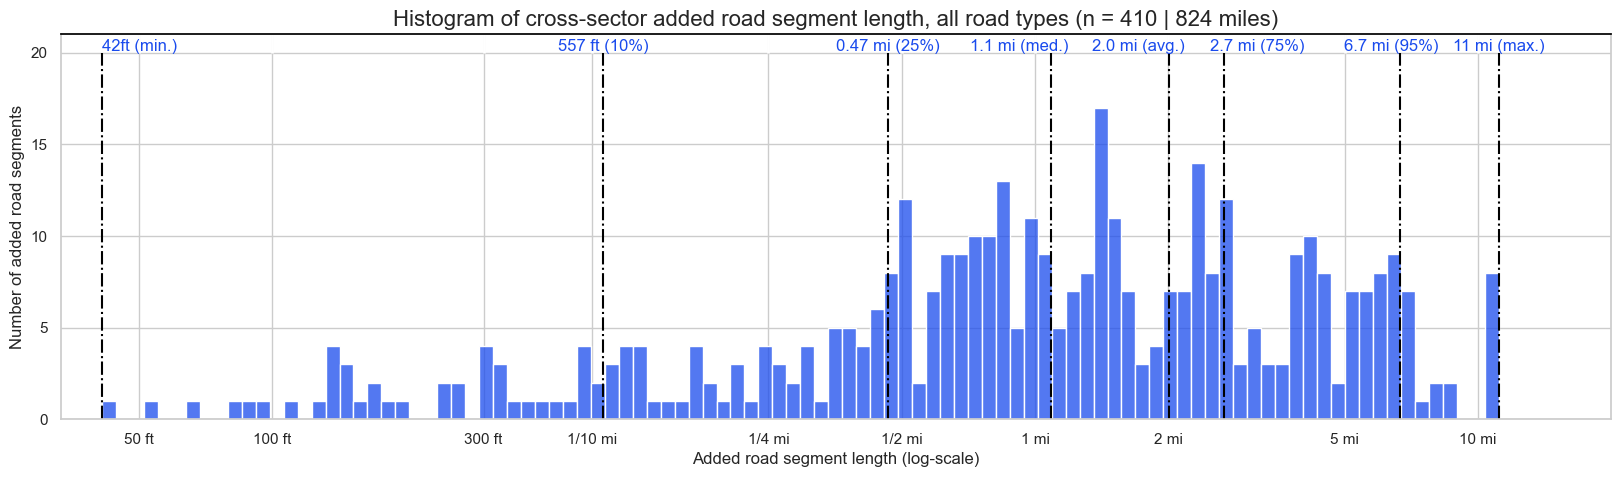

In [241]:
# compute the histogram of the added distribution - for cross-sector added streets
working_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == 3, :].copy()
w_ds_df = ds_df.loc[(ds_df['street_status'] == 3) & 
                    (ds_df['stat'] != '99%'), :].copy()


sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))

ax.set_ylim(0, 21)
ax.set_xlim(-2.2, 1.3)

my_plot = sns.histplot(data = working_wms_gdf, x = 'dist_miles_log',
                      color='#1a4bed', bins = 100)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 21, 5))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

# total added streets
n_added = working_wms_gdf.shape[0]
n_added =  f"{n_added:,}"

tot_miles = working_wms_gdf['dist_miles'].sum()
tot_miles = f"{int(round(tot_miles, 0)):,}"

my_title = "Histogram of cross-sector added road segment length, all road types (n = {} | {} miles)".format(n_added, tot_miles)

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Added road segment length (log-scale)')
plt.ylabel(ylabel = "Number of added road segments")

# x tick positions
x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 5, 10]
x_ticks = [np.log10(xtl) for xtl in x_tick_labels]

# x tick labels
x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '5 mi', '10 mi']

my_plot.set_xticks(ticks = x_ticks)
my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)

# white out the top portion of the ticks
for xt in x_ticks:
    my_plot.vlines(x = xt, ymin = 20, ymax = 25, color = 'white', linestyles = 'solid', linewidth = 2)

# add vertical lines at some descriptive statistics points
my_plot.vlines(x = w_ds_df['dist_miles_log'], ymin = 0, ymax = 20, color = w_ds_df['color_list'], linestyles = 'dashdot')

# add text for the descriptive stats
w_ds_df['text_x_pos'] = w_ds_df['text_x_pos'] + [0,0,0,-.05,-.07,-.03, .03,0]
w_ds_df['text_ha'] = ['left', 'center', 'center', 'right', 'center', 'left', 'center', 'center']
for ir, row in w_ds_df.iterrows():
    my_plot.text(x = row['text_x_pos'], y = 20.1, s = row['text'], horizontalalignment = row['text_ha'], color = '#1a4bed')

output_file_name = '..\\graphics\\histogram_cs_ALL_streets.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [ ]:
# average cross sector added segment is 2.0 miles.
# That makes sense as cross-sector connections are going to be longer because 
# of water bodies.

# histogram of each type of street

In [246]:
st_type_df = pd.pivot_table(data = wms_gdf, index = ['ord_street_type'],
                         columns = ['street_status_desc'], values = ['dist_miles'],
                        aggfunc='sum', fill_value = 0).reset_index()

In [247]:
st_type_df.head()

ord_street_type                 dist_miles  \
street_status_desc                 added_street: cross-sector   
0                              AVE                 560.253713   
1                             BLVD                   0.046053   
2                               CT                   3.848201   
3                               DR                   9.561867   
4                               LN                   0.000000   

                                                
street_status_desc added_street: within-sector  
0                                   431.877647  
1                                     0.467329  
2                                     0.022490  
3                                     1.246189  
4                                     2.066653

In [249]:
st_type_df.columns = [''.join(cn).replace('dist_miles', '') for cn in st_type_df.columns]

In [250]:
st_type_df.head()

,ord_street_type,added_street: cross-sector,added_street: within-sector
0,AVE,560.253713,431.877647
1,BLVD,0.046053,0.467329
2,CT,3.848201,0.022490
3,DR,9.561867,1.246189
4,LN,0.000000,2.066653


In [252]:
st_type_df.columns = ['ord_street_type', 'total_miles_cross_sector', 'total_miles_within_sector']

In [253]:
ds_df_list = []
for ss in [2,3]:
    temp_wms_gdf = wms_gdf.loc[wms_gdf['street_status'] == ss, :]
    ds_df = temp_wms_gdf[['ord_street_type', 'dist_miles']].groupby(['ord_street_type'])['dist_miles'].describe().reset_index(names = ['ord_street_type'])
    ds_df['street_status'] = ss
    ds_df_list.append(ds_df)
ds_df = pd.concat(ds_df_list)

In [254]:
ds_df.head()

,ord_street_type,count,mean,std,min,25%,50%,75%,max,street_status
0,AVE,1728.0,0.249929,0.402936,0.002857,0.030614,0.095037,0.269936,3.739595,2
1,BLVD,9.0,0.051925,0.079263,0.001021,0.010911,0.019715,0.046605,0.255118,2
2,CT,1.0,0.022490,NaN,0.022490,0.022490,0.022490,0.022490,0.022490,2
3,DR,14.0,0.089013,0.102982,0.004334,0.029131,0.051434,0.110189,0.383551,2
4,LN,9.0,0.229628,0.321047,0.015234,0.018194,0.039581,0.408942,0.903147,2


# within-sector added streets

In [257]:
w_ds_df = ds_df.loc[ds_df['street_status'] == 2, :]
for ir, row in ds_df.iterrows():
    # let's make a graphic showing the distances
    sns.set_theme(style = "whitegrid")
    f, ax = plt.subplots(figsize = (20, 5))

    # set the top part of the plot frame - the spine - to black
    ax.spines['top'].set_edgecolor(color = 'black')

    x_max = row['max']
    ost = row['ord_street_type']    
    
    if x_max > 1:
        xlim_max = .75
    else:
        xlim_max = 0
    ax.set_xlim(-3.2, xlim_max)

    temp_gdf = wms_gdf.loc[wms_gdf['ord_street_type'] == ost, :]
    my_plot = sns.histplot(data = temp_gdf, x = 'dist_miles_log',
                          color='#ca0020', bins = 100)
    
    # total added streets
    n_added = temp_gdf.shape[0]
    n_added =  f"{n_added:,}"

    tot_miles = temp_gdf['dist_miles'].sum()    
    dist_units = 'miles'
    if tot_miles < .25:
        tot_dist = int(round(temp_gdf['dist'].sum(), 0))
        dist_units = 'feet'        
    elif tot_miles >= .25 and tot_miles <= 5:    
        tot_dist = tot_miles
        tot_dist = round(tot_dist, 2)        
    else:
        tot_dist = int(round(tot_miles, 0))        
        
    my_title =   "Histogram of within-sector added road segment length: {} (n = {} | {} {})".format(ost, n_added, tot_dist, dist_units )
    
    plt.title(label = my_title, fontsize = 16)
    plt.xlabel(xlabel = 'Added road segment length (log-scale)')
    plt.ylabel(ylabel = "Number of added road segments")
    
    if x_max > 1:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']
    else:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi']
        
    x_ticks = [np.log10(xtl) for xtl in x_tick_labels]
    
    my_plot.set_xticks(ticks = x_ticks)
    my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)    
    
    
    output_file_name = '..\\graphics\\histogram_ws_{}.png'.format(row['ord_street_type'])
    output_file_name = os.path.normpath(output_file_name)
    print(output_file_name)
    my_plot.get_figure().savefig(fname = output_file_name)
    plt.close()

..\graphics\histogram_ws_AVE.png
..\graphics\histogram_ws_BLVD.png
..\graphics\histogram_ws_CT.png
..\graphics\histogram_ws_DR.png
..\graphics\histogram_ws_LN.png
..\graphics\histogram_ws_PKWY.png
..\graphics\histogram_ws_PL.png
..\graphics\histogram_ws_RD.png
..\graphics\histogram_ws_ST.png
..\graphics\histogram_ws_WAY.png
..\graphics\histogram_ws_AVE.png
..\graphics\histogram_ws_BLVD.png
..\graphics\histogram_ws_CT.png
..\graphics\histogram_ws_DR.png
..\graphics\histogram_ws_RD.png
..\graphics\histogram_ws_ST.png
..\graphics\histogram_ws_WAY.png


# cross-sector added streets

In [258]:
w_ds_df = ds_df.loc[ds_df['street_status'] == 3, :]
for ir, row in ds_df.iterrows():
    # let's make a graphic showing the distances
    sns.set_theme(style = "whitegrid")
    f, ax = plt.subplots(figsize = (20, 5))

    # set the top part of the plot frame - the spine - to black
    ax.spines['top'].set_edgecolor(color = 'black')

    x_max = row['max']
    ost = row['ord_street_type']    
    
    if x_max > 1:
        xlim_max = .75
    else:
        xlim_max = 0
    ax.set_xlim(-3.2, xlim_max)

    temp_gdf = wms_gdf.loc[wms_gdf['ord_street_type'] == ost, :]
    my_plot = sns.histplot(data = temp_gdf, x = 'dist_miles_log',
                          color='#ca0020', bins = 100)
    
    # total added streets
    n_added = temp_gdf.shape[0]
    n_added =  f"{n_added:,}"

    tot_miles = temp_gdf['dist_miles'].sum()    
    dist_units = 'miles'
    if tot_miles < .25:
        tot_dist = int(round(temp_gdf['dist'].sum(), 0))
        dist_units = 'feet'        
    elif tot_miles >= .25 and tot_miles <= 5:    
        tot_dist = tot_miles
        tot_dist = round(tot_dist, 2)        
    else:
        tot_dist = int(round(tot_miles, 0))        
        
    my_title =   "Histogram of cross-sector added road segment length: {} (n = {} | {} {})".format(ost, n_added, tot_dist, dist_units )
    
    plt.title(label = my_title, fontsize = 16)
    plt.xlabel(xlabel = 'Added road segment length (log-scale)')
    plt.ylabel(ylabel = "Number of added road segments")
    
    if x_max > 1:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1, 2, 3]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi', '2 mi', '3 mi']
    else:
        x_tick_labels = [50 / 5280, 100 / 5280, 300 / 5280, .1, .25, .5, 1]
        x_tick_label_text = ['50 ft', '100 ft', '300 ft',  '1/10 mi', '1/4 mi', '1/2 mi', '1 mi']
        
    x_ticks = [np.log10(xtl) for xtl in x_tick_labels]
    
    my_plot.set_xticks(ticks = x_ticks)
    my_plot.set_xticklabels(labels = x_tick_label_text, rotation=0)    
    
    
    output_file_name = '..\\graphics\\histogram_cs_{}.png'.format(row['ord_street_type'])
    output_file_name = os.path.normpath(output_file_name)
    print(output_file_name)
    my_plot.get_figure().savefig(fname = output_file_name)
    plt.close()

..\graphics\histogram_cs_AVE.png
..\graphics\histogram_cs_BLVD.png
..\graphics\histogram_cs_CT.png
..\graphics\histogram_cs_DR.png
..\graphics\histogram_cs_LN.png
..\graphics\histogram_cs_PKWY.png
..\graphics\histogram_cs_PL.png
..\graphics\histogram_cs_RD.png
..\graphics\histogram_cs_ST.png
..\graphics\histogram_cs_WAY.png
..\graphics\histogram_cs_AVE.png
..\graphics\histogram_cs_BLVD.png
..\graphics\histogram_cs_CT.png
..\graphics\histogram_cs_DR.png
..\graphics\histogram_cs_RD.png
..\graphics\histogram_cs_ST.png
..\graphics\histogram_cs_WAY.png


In [ ]:
ds_st_df.head()

In [ ]:
col_names = ['ord_street_type', 'street_status_desc', 'dist_miles']
ds_st_df = gdf[col_names].groupby(col_names[:-1]).agg(n_segments = ('dist_miles', 'size'),
                                                      n_miles = ('dist_miles', 'sum')).reset_index()

In [ ]:
ds_st_df.head()

In [ ]:
col_names = ['street_status_desc', 'dist_miles']
all_ds_st_df = gdf[col_names].groupby(col_names[:-1]).agg(n_segments = ('dist_miles', 'size'),
                                                      n_miles = ('dist_miles', 'sum')).reset_index()

In [ ]:
all_ds_st_df['ord_street_type'] = 'ALL'

In [ ]:
col_names = ['ord_street_type', 'street_status_desc', 'n_segments', 'n_miles']
all_ds_st_df = all_ds_st_df[col_names]

In [ ]:
ds_st_df = pd.concat(objs = [all_ds_st_df, ds_st_df])

In [ ]:
ds_st_df.head()

In [ ]:
ds_st_df['n_miles_log'] = np.log(ds_st_df['n_miles'])
ds_st_df['street_status_desc'] = ds_st_df['street_status_desc'].str.replace('_', ' ')

In [ ]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))
ax.set_ylim(0, 1600)

# these are the same green, black, and red colors used in qGIS. 
my_color_palette = {'continuous street': '#33a02c',
'discontinuous street': '#000000',
'added street': '#ca0020'}

my_plot = sns.barplot(data = ds_st_df, x = 'ord_street_type', y = 'n_miles',
                      hue = 'street_status_desc', palette=my_color_palette)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 1601, 200))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_title = "Total miles by road types and road status"

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Road type')
plt.ylabel(ylabel = "Miles")

plt.legend(title='Road status')

output_file_name = '..\\graphics\\barplot_miles.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()

In [ ]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20, 5))
ax.set_ylim(0, 22000)

my_plot = sns.barplot(data = ds_st_df, x = 'ord_street_type', y = 'n_segments',
                      hue = 'street_status_desc', palette=my_color_palette)

# set the top part of the plot frame - the spine - to black
ax.spines['top'].set_edgecolor(color = 'black')

y_ticks = list(range(0, 22001, 2000))
y_tick_labels_formatted = ['{:,}'.format(ytl) for ytl in y_ticks]   

my_plot.set_yticks(ticks = y_ticks)
my_plot.set_yticklabels(labels = y_tick_labels_formatted, rotation=0)

my_title = "Total segments by road types and road status"

plt.title(label = my_title, fontsize = 16)
plt.xlabel(xlabel = 'Road type')
plt.ylabel(ylabel = "Number of segments")

plt.legend(title='Road status')

output_file_name = '..\\graphics\\barplot_segment_count.png'
output_file_name = os.path.normpath(output_file_name)
print(output_file_name)
my_plot.get_figure().savefig(fname = output_file_name)
plt.show()